# XGBoost Regression Model

The extreme gradient boosting model [1] works by using ensemble learning with a series of regression trees. The model aims to choose the regression tree that minimises a regularised loss function that measures the difference between the predicted values and the true values of the target variable. The loss function penalises model complexity so the end result is a simple tree with a minimal error score. Addtionally the loss function's regularisation term avoid overfitting. The XGBoost model is often the best perfoming supervised machine learning model so we expect it to perform better than the random forest model when predicting PM10 concentration for this dataset.

We chose to use the XGBoost for our second model with the uncleaned dataset because it has been used for similar regression studies in the literature and in one example has been used to predict pollutants in a similar setting [2]. In this study XGBoost was the best performing model when predicting PM2.5 concentration, compared to other regression models such as random forest and support vector regression, with the lowest RMSE and MAE scores.

To implement this model we used the code from another example of XGBoost regression where the model is used to predict house prices[3].


In [53]:
#Library requirements
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV, train_test_split
from numpy import absolute

## Data Processing

As this is the second model using the uncleaned dataset we just need to filter the dataset to europe and select our variables and drop any missing values in our target variable PM10 concentration.

In [29]:

with open('/Users/ilc04/OneDrive - University of Bristol/DST/DST_Assessment_1/who_data.csv', encoding='utf-8', errors='ignore') as f:
   df = pd.read_csv(f)

   eu_df = df[df['who_region'] == '4_Eur']
   eu_df = eu_df[['year', 'pm10_concentration', 'pm25_concentration', 'no2_concentration','population', 'latitude', 'longitude']]

   eu_df = eu_df.dropna(subset = ['pm10_concentration'])



The data is split into X and y to separate it into input data and the variable we are predicting. X and y are then split into training and testing data using the function from the Scikit-learn package.

In [32]:
X = eu_df.drop(columns = 'pm10_concentration')
y = eu_df['pm10_concentration']
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Running the Model
Then the model is initialised using default parameters and run using 10-fold cross validation. During the cross validation the mean of the RMSE for each prediction is calculated 

In [35]:
model = xgb.XGBRegressor(random_state=42)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
# Evaluate model
scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
scores = absolute(scores)
print('Mean RMSE before grid search: %.3f (%.3f)' % (scores.mean(), scores.std()) )


Mean RMSE before grid search: -4.885 (0.323)


## Hyperparameter Optimisation
To see if we can improve the RMSE even further now we tune the hyperparameters of the model using GridSearch.CV and cross validation from the Scikit-learn package. The grid search method runs an "exhaustive search over specified parameter values for an estimator" [4], using a "fit and score" method, calculates a score for every combination of parameter values through cross validation and outputs the best combination of parameter values. This code was adapted from an example of hyperparameter tuning on an XGBoost classification model [5].

In [38]:
param_grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.01, 0.1, 0.3]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 1.0}
Best score: 0.794581124654897


Now we initalise a new model with the best parameter values chosen by the grid search.

In [41]:
newmodel = xgb.XGBRegressor(**grid_search.best_params_, random_state=42)
newscores = cross_val_score(newmodel, X, y, scoring = 'neg_root_mean_squared_error', cv = cv, n_jobs = -1)
newscores = absolute(newscores)
print('Mean RMSE after grid search: %.3f (%.3f)' % (newscores.mean(), newscores.std()) )


Mean RMSE after grid search: 4.761 (0.354)


## Results

| Tuned or Untuned Model | Mean RSME | Standard Deviation |
|:---------------|:--------------:|:--------------:|
| Untuned Model| 4.761 | 0.354 |
| Tuned | 4.885 | 0.323 |


The RMSE after tuning has improved very minimally but this may be because the RMSE value was already small before tuning. 

Now we visualise the results; the values predicted by the XGBoost model are plotted against the true values from the dataset.

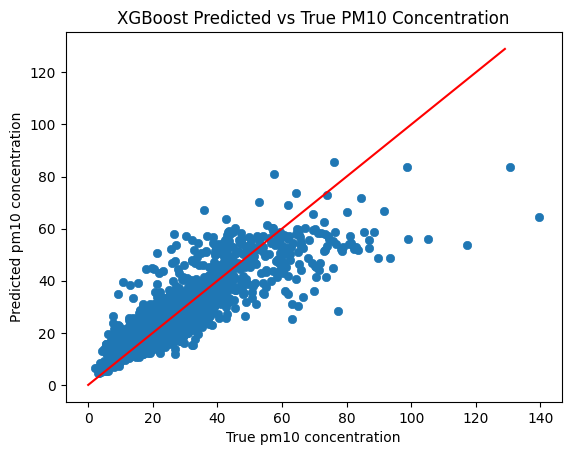

In [43]:
train = xgb.train(grid_search.best_params_, xgb.DMatrix(X_train, label=y_train))
predictions = train.predict(xgb.DMatrix(X_test))

plt.scatter(y_test, predictions, linewidths=0.5, marker = 'o')
plt.plot(range(0,130), range(0,130), color = 'red')
plt.xlabel('True pm10 concentration')
plt.ylabel('Predicted pm10 concentration')
plt.title('XGBoost Predicted vs True PM10 Concentration')
plt.show(block = False)


This graph clearly shows the XGBoost model is very good at predicting the smallest values for PM10 concentration and the error gets larger as the values increase. It appears that the largest values were often underestimated, but some may be outliers.



#Bibliography

[1] T. Chen, C. Guestrin, XGBoost: A Scalable Tree Boosting System. 2016, Association for Computing Theory
URL: https://dl.acm.org/doi/abs/10.1145/2939672.2939785

[2] J. Li, X. An, et al, Application of XGBoost algorithm in the optimization of pollutant concentration, Atmospheric Research, Volume 276, 2022
URL: https://www.sciencedirect.com/science/article/pii/S0169809522002241

[3] J. Brownlee, XGBoost for Regression, 2021, Machine Learning Mastery
URL: https://machinelearningmastery.com/xgboost-for-regression/

[4] GridSearch.CV, Scikit-learn
URL: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

[5] GridSearch XGBoost Hyperparameters, XGBoosting
URL: https://xgboosting.com/grid-search-xgboost-hyperparameters/

